## METHODOLOGY
1. Subset Data 7-40 in length
2. Undersample the undetected class
3. Integer encode the peptides. 
4. Train Test Validation Split
5. Create the model
6. Fit the transformer
7. Evaluate the model 

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import time
import math
import re

import sklearn.model_selection
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras

from transformer import TokenAndPositionEmbedding, TransformerBlock

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from textwrap import wrap
import seaborn as sns

## 2. Import Data

In [ ]:
df =  pd.read_csv('NSAF_quant_missed_cleaved_peptides_excluded.csv') # read in the data

In [ ]:
df = df[['Sequence','Detectability', 'SMT', 'NSAF', 'Protein']]

In [ ]:
df.shape

In [ ]:
df

In [ ]:
df["Detectability"].sum() # number of detected peptides

##  Subset Peptide Sequences  between 7- 40 amino acids in length 

In [ ]:
detected_peptides = df[df['Detectability'] == 1] # detected peptides

In [ ]:
undetected_peptides = df[df['Detectability'] == 0] # undetected peptides

In [ ]:
undetected_peptides.shape

In [ ]:
detected_peptides.shape

In [ ]:
detected_peptides = detected_peptides.loc[(detected_peptides["Sequence"].str.len()>=7) & 
                                          (detected_peptides["Sequence"].str.len()<=40)].reset_index(drop=True)

In [ ]:
undetected_peptides = undetected_peptides.loc[(undetected_peptides["Sequence"].str.len()>=7) & 
                                              (undetected_peptides["Sequence"].str.len()<=40)].reset_index(drop=True)

## Random Sampling to Balance Data

In [ ]:
detected_peptides.shape # number of detected peptides

In [ ]:
undetected_peptides.shape

In [ ]:
# undetected peptides balanced by number of rows of detected peptides..
undetected_peptides_balanced = undetected_peptides.sample(n=detected_peptides.shape[0], 
                                                         random_state=42).reset_index(drop=True)

In [ ]:
unused_undetected = undetected_peptides[~undetected_peptides["Sequence"].isin
                                        (undetected_peptides_balanced["Sequence"])]
unused_undetected.shape

# drop unnessesary columns 

In [ ]:
detected_peptides.drop(columns='Protein', axis=1, inplace=True)
undetected_peptides_balanced.drop(columns='Protein', axis=1 ,inplace=True)

In [ ]:
detected_peptides

In [ ]:
undetected_peptides

# Split into Train and Test Sets 

In [ ]:
# detected peptides
X_trainP, X_testP, y_trainP, y_testP = sklearn.model_selection.train_test_split(
    detected_peptides, detected_peptides['Detectability'], test_size=0.3, random_state=42)

In [ ]:
 #undetected peptides
X_trainN, X_testN, y_trainN, y_testN = sklearn.model_selection.train_test_split(
    undetected_peptides_balanced, undetected_peptides_balanced['Detectability'], test_size=0.3, random_state=42)

In [ ]:
print(X_trainP.shape)
print(X_testP.shape)
print('')
print(X_trainN.shape)
print(X_testN.shape)

# split training into train and validation sets 

In [ ]:
# detected peptides
X_trainP, X_valP, y_trainP, y_valP = sklearn.model_selection.train_test_split(
    X_trainP, y_trainP, test_size=0.3, random_state=42)

In [ ]:
# undetected peptides
X_trainN, X_valN, y_trainN, y_valN = sklearn.model_selection.train_test_split(
    X_trainN, y_trainN, test_size=0.3, random_state=42) 

In [ ]:
print(X_trainP.shape)
print(X_valP.shape)
print('')
print(X_trainN.shape)
print(X_valN.shape)

In [ ]:
# create final training and validation sets 
X_train = pd.concat([X_trainP, X_trainN])
X_val = pd.concat([X_valP] + [X_valN])
y_train = pd.concat([pd.Series(y_trainP)] + [pd.Series(y_trainN)])
y_val = pd.concat([pd.Series(y_valP)] + [pd.Series(y_valN)])

In [ ]:
print(X_train.shape)
print(X_val.shape)
print('')
print(y_train.shape)
print(y_val.shape)

In [ ]:
X_train

In [ ]:
# check validation set is not in train
print(len(X_val[X_val["Sequence"].isin(X_train["Sequence"])]))

# create final test set 

In [ ]:
# create final test set
X_test = pd.concat([X_testP, X_testN])
y_test = pd.concat([pd.Series(y_testP)] + [pd.Series(y_testN)])
print(X_test.shape)
print(y_test.shape)

In [ ]:
# check test is not in train or validation
print(len(X_test[X_test["Sequence"].isin(X_val["Sequence"])]))
print(len(X_test[X_test["Sequence"].isin(X_train["Sequence"])]))

## 5. Integer encode Raw  Peptide Sequences for Transformer

In [ ]:

max_length = 40
def convertPeptide(peptide_sequence, max_length): # set the maximum length of the peptide sequence
    amino_acid = {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,'U':18, 'V': 19, 'W': 20, 'Y': 21} # create a dictionary of amino acids
    integer = [] # initialize an empty list
    for i in range(max_length):
        if i < len(peptide_sequence): #if the index is less than the length of the peptide sequence
            integer.append(amino_acid[peptide_sequence[i]]) #append the value of the amino acid at the index to the integer
        else: #if the index is greater than the length of the peptide sequence
            integer.append(0) #append zero to the integer list
    return np.array(integer)#return the integer as a numpy array


### Shuffle the data inputs

In [ ]:
X_train = shuffle(X_train, random_state=42).reset_index(drop=True)
y_train = shuffle(y_train, random_state=42).reset_index(drop=True)

In [ ]:
X_val = shuffle(X_val, random_state=42).reset_index(drop=True)
y_val = shuffle(y_val, random_state=42).reset_index(drop=True)

In [ ]:
X_test = shuffle(X_test, random_state=42).reset_index(drop=True)
y_test = shuffle(y_test, random_state=42).reset_index(drop=True)

## Separate out the features 

In [ ]:
X_train_peptide = X_train['Sequence'].apply(convertPeptide, args=(max_length,))

In [ ]:
X_train_peptide # the training set is now a series of numpy arrays

In [ ]:

X_train_quant= X_train.iloc[:,2:] # get the quantitative features for the training set


In [ ]:
X_train_quant

In [ ]:
# X_train_quant = X_train_quant.to_frame()    # convert the series to a numpy array

In [ ]:
# X_train_quant['log'] = (X_train_quant['SMT'] + 1).transform(np.log)

In [ ]:
# X_train_quant.drop(columns='SMT', inplace=True)

In [ ]:
X_train_quant

In [ ]:
# X_train_quant = X_train_quant.to_numpy() # convert the series to a numpy array

In [ ]:
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_quant = scaler.fit_transform(X_train_quant)

In [ ]:
X_train_quant

In [ ]:
X_val_peptide = X_val['Sequence'].apply(convertPeptide, args=(max_length,)) # get the encoded peptide sequences for the validation set

In [ ]:
X_val_peptide # validation set

In [ ]:
X_val_quant = X_val.iloc[:,2:] # get the quantitative values for the validation set

In [ ]:
X_val_quant

In [ ]:
# X_val_quant = X_val_quant.to_frame() # convert the series to a numpy array

In [ ]:
# X_val_quant['log'] = (X_val_quant['SMT'] +1).transform(np.log) # log the quantitative values

In [ ]:
# X_val_quant.drop(columns='SMT', inplace=True) # drop the SMT column

In [ ]:
X_val_quant # validation set with quantitative values

In [ ]:
X_val_quant = scaler.transform(X_val_quant) # scale the quantitative values for the validation set

In [ ]:
X_test_peptide = X_test['Sequence'].apply(convertPeptide, args=(max_length,)) # get the encoded peptide sequences for the test set

In [ ]:
X_test_peptide # test set

In [ ]:
X_test_quant = X_test.iloc[:,2:]  # get the quantitative values for the test set


In [ ]:
# X_test_quant = X_test_quant.to_frame() # convert the series to a df

In [ ]:
X_test_quant = scaler.transform(X_test_quant)# scale the quantitative values for the test set

In [ ]:
X_test_quant

In [ ]:
# X_test_quant['log'] = (X_test_quant['SMT'] +1).transform(np.log) # log the SMT values

In [ ]:
# X_test_quant.drop(columns='SMT', inplace=True) # drop the SMT column

In [ ]:
# X_test_quant = X_test_quant.to_numpy().flatten() # convert the series to a numpy array

In [ ]:
# convert the quantitative values to numpy arrays
X_train_peptide = np.array(X_train_peptide.to_list()) # convert the series to a numpy array for the training set

In [ ]:
X_val_peptide = np.array(X_val_peptide.to_list()) # convert the series to a numpy array for the validation set

In [ ]:
X_test_peptide = np.array(X_test_peptide.to_list()) # convert the series to a numpy array for the test set

In [ ]:
X_train_peptide[0] # (the first peptide sequence, with the integer coversion applied)

In [ ]:
X_train_peptide[9][:40] # take 40 amino acids of the 9th peptide, peptides < 40 are appended with 0s.

In [ ]:
# import EarlyStopping from keras
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# help(EarlyStopping)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',  mode = 'min', patience=50, verbose=1) # set the early stopping parameters to monitor the validation loss and minimize the loss

### BUILD TRANSFORMER

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32 # Hidden layer size in feed forward network inside transformer

main_input = tf.keras.layers.Input(shape=(40,), name= 'sequence')
# embed each peptide into a 40-dimensional vector
embedding_layer = TokenAndPositionEmbedding(40, 22, embed_dim) # create a token and position embedding layer
x = embedding_layer(main_input) # apply the token and position embedding layer to the main input
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim) # create a transformer block
x = transformer_block(x) # apply the transformer block to the embedding layer

y = tf.keras.layers.GlobalAveragePooling1D()(x) # apply global average pooling to the transformer block output
auxiliary_output = tf.keras.layers.Dense(1, activation='sigmoid', name = 'aux_output')(y)
 # apply a dense layer to the output of the transformer block, y is the output of the global average pooling layer
 # create a dense layer with 1 output for the auxiliary output
auxiliary_input = tf.keras.layers.Input(shape=(2,), name='reporter_ion_quant') # create an input layer for the auxiliary input




# concatenate the output of the transformer block and the auxiliary input
x = tf.keras.layers.concatenate([auxiliary_output, auxiliary_input]) 




x = tf.keras.layers.Dense(64, activation='relu')(x) # apply a dense layer to the concatenated output of the transformer block and the auxiliary input
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)


main_output = tf.keras.layers.Dense(1, activation='sigmoid', name='main_output') (x) # apply a dense layer to the output of the dense layer, x is the output of the dense layer

model = tf.keras.Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output]) # create a model (defining it here because we need to specify the input and output layers)

# optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # create an optimiser

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 

model.compile(loss='binary_crossentropy', optimizer= optimiser, metrics=['accuracy'], loss_weights= [1.,0.2]) # compile the model

In [ ]:
print(model.summary())
keras.utils.plot_model(model, "keras_model_sequence_SRI20date.png", show_shapes=True, show_layer_names=True) #PLOT ARCHITECTURE


In [ ]:
y_train = y_train.to_numpy() # convert the series to a numpy array

In [ ]:
y_val = y_val.to_numpy() # convert the series to a numpy array

In [ ]:
# X_val_quant = X_val_quant.to_numpy() # convert the series to a numpy array

In [ ]:
# X_val_quant = X_val_quant.flatten() # flatten the numpy array

In [ ]:
# X_train_quant = X_train_quant.to_numpy().flatten() # convert the series to a numpy array

In [ ]:
start_time = time.time()

history_model = model.fit([X_train_peptide, X_train_quant],  [y_train,y_train], validation_data= ([X_val_peptide, X_val_quant],[y_val,y_val]), callbacks=[early_stop] ,epochs=250, batch_size=128, verbose=2) # train the model with y_train and y_val as the labels
print("")
print("Training time: ", time.time() - start_time)

In [ ]:
history_model

In [ ]:
model_loss = pd.DataFrame(history_model.history)

In [ ]:
model_loss

In [ ]:
model_loss.to_csv("model_loss_sequence_min_max_SRI_NSAF_new_25date.csv") # save the model loss to a csv file for the sequence model

In [ ]:
# plot the model loss and training loss against the number of epochs
# enlarge the figure size to make it easier to see
plt.figure(figsize=(7,5))
plt.plot(model_loss['loss'])
plt.plot(model_loss['val_loss'])
plt.title(' Transformer Training and Validation Loss (Sequence + NSRI)', fontsize=15)
plt.ylabel('Loss', fontsize=13)
plt.xlabel('Epochs', fontsize=13)
plt.legend(['train loss', 'validation loss'], loc='upper right', fontsize=10)
# x limit for the loss plot to 192
plt.xlim(0,250)


#plt.savefig('Transformer__Training_Val_loss_sequence_SMT_noise_07data128batches.png', dpi=300)
plt.show()



In [ ]:
# plot the model training and validation accuracy against the number of epochs
plt.plot(model_loss['main_output_accuracy'])
plt.plot(model_loss['val_main_output_accuracy'])
# enlarge the text size to make it easier to see
plt.title(' Transformer Training and Validation Accuracy (Sequence + NSRI )', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', fontsize=10)
# x limit for the accuracy plot to 192
plt.xlim(0, 250)
#plt.savefig('Transformer_Training_Val_accuracy_sequence_SMT_noise_07.png', dpi=300)
plt.show()


## Save Model

In [ ]:
# save the model to a h5 file
history_model.model.save('model_sequence_SRI_NSAF_min_max_25date') 

In [ ]:
train_results = model.evaluate([X_train_peptide, X_train_quant],[y_train,y_train]) # evaluate the model on the training data )
print("")
print("Training results: ", train_results)


In [ ]:
train_results

In [ ]:
val_results = model.evaluate([X_val_peptide,X_val_quant], [y_val, y_val]) # evaluate the model on the validation data
print("")
print("Validation results: ", val_results)

## Model Prediction 

In [ ]:
Model_prediction_df = pd.DataFrame({'Peptide': X_test['Sequence'], 'Detectability': y_test})

In [ ]:
Model_prediction_df

In [ ]:
test_predictions =model.predict([np.array([convertPeptide(x, max_length) for x in Model_prediction_df['Peptide']]), np.array(X_test_quant)],  verbose=1)

In [ ]:
Model_prediction_df['Prediction'] = test_predictions[0].flatten()

In [ ]:
Model_prediction_df.reset_index(drop=True, inplace=True)

In [ ]:
Model_prediction_df

In [ ]:
# save the model predictions to a csv file
Model_prediction_df.to_csv("model_predictions_sequence_min_max_SRI__SAF_no_missed_cleaved_25date.csv", sep="\t", index=False)

In [ ]:
# get confusion matrit and print classification report

In [2]:
# read the model predictions from a csv file if needed
Model_prediction_df = pd.read_csv("model_predictions_sequence_min_max_SRI__SAF_no_missed_cleaved_25date.csv", sep="\t")

In [3]:
import seaborn as sns

In [4]:
 colors = ["#9f04ff", "#ffa304"]

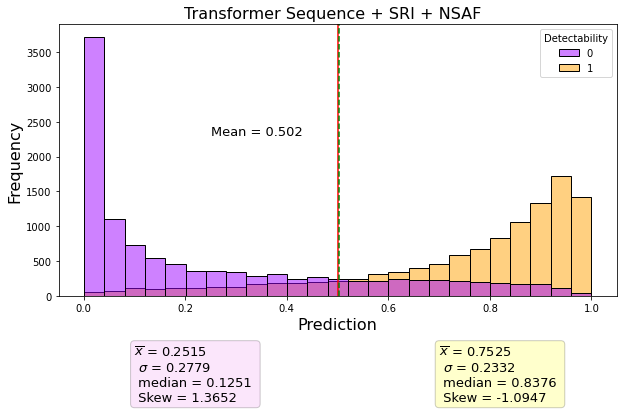

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(data=Model_prediction_df, x=Model_prediction_df['Prediction'], hue=Model_prediction_df['Detectability'], palette= colors , stat='count', bins=25)
ax.set_title('Transformer Sequence + SRI + NSAF  ', fontsize=16)

ax.set_xlabel('Prediction', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

plt.axvline(x=Model_prediction_df['Detectability'].mean(), color='r')
plt.axvline(x=Model_prediction_df['Prediction'].mean(), color='g', ls='--')
plt.text(0.25,2300, ('Mean = {:.3f}'.format(Model_prediction_df['Prediction'].mean())), fontsize=13)

skew = round(((Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].mean() - Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].median()) * 3)/( Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].std()), 4)
mean = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].mean(), 4)
median = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].median(), 4)

# for the detected 1
# calculate the mode of the predictions for the detected 1

sd = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].std(), 4)

textstr = "$\overline {x}$" + f" = {mean} \n $\sigma$ = {sd} \n median = {median} \n Skew = {skew}"
props = dict(boxstyle='round', facecolor='yellow', alpha=0.2)
plt.text(0.7,-1500, textstr, fontsize=13, bbox = props)


skew = round(((Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].mean() - Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].median()) * 3)/( Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].std()), 4)
mean = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].mean(), 4)
median = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].median(), 4)

# get the mode of the data where prediction is 1

sd = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].std(), 4)
textstr = "$\overline {x}$" + f" = {mean} \n $\sigma$ = {sd} \n median = {median} \n Skew = {skew}"
props = dict(boxstyle='round', facecolor='violet', alpha=0.2)
plt.text(0.1,-1500, textstr, fontsize=13, bbox = props)

# calculate skew 3(mean- median)/ standard deviation

plt.savefig('Transformer_model_predictions_sequence_freq_min_max_scaled_SRI_noise_new_20date.png', dpi=300, bbox_inches='tight')
#plt.savefig('Transformer_model_predictions_sequence_freq_min_max_scaled_SRI_noise_new_20date.png', dpi=300)

In [7]:
# confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(Model_prediction_df['Prediction']))

In [ ]:
# get the classification report and plot confusion matrix

print(sklearn.metrics.classification_report(y_test, np.rint(Model_prediction_df['Prediction'])))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, np.rint(Model_prediction_df['Prediction']))

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, round(Model_prediction_df['Prediction']), average='binary')

In [ ]:
from sklearn import metrics
MCC = metrics.matthews_corrcoef(y_test, np.rint(Model_prediction_df['Prediction']))
print("MCC:",MCC)


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, np.rint(Model_prediction_df['Prediction']), average='binary')

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test, np.rint(Model_prediction_df['Prediction']), average='binary')

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt


In [ ]:
test_predictions[0]

In [ ]:
classes = np.unique(y_test)
fig, ax = plt.subplots()
#cm = confusion_matrix(y_test,  , labels=classes)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.savefig('Transformer_sequence__SRI_min_max_confusion_no_missed_cleaved_matrix_20date.png', dpi=200)
plt.show()

In [8]:
def get_confusion_matrix_scores(df, peptide_col_index, true_col_index, pred_col_index): # df is the dataframe, peptide_col_index is the index of the peptide column, true_col_index is the index of the true column, pred_col_index is the index of the predicted column
    scores_df = df.iloc[: , [peptide_col_index, true_col_index, pred_col_index]].copy() # create a copy of the dataframe
    scores_df['pred_round'] = np.rint(scores_df.iloc[:, 2]).astype(int) # round to nearest integer
    scores_df['Length'] = scores_df.iloc[:, 0].str.len() # get length of peptide
    # count the number of missed cleavages, ignoring the last character of the peptide
    scores_df['Missed Cleavages'] = scores_df.iloc[:, 0].str.slice(0, -1).str.count('K') + scores_df.iloc[:, 0].str.slice(0, -1).str.count('R') # get the number of missed cleavages
    scores_df['pred_class'] = 0 # 0 = false, 1 = true
    # set the pred_class to 1 if the predicted class is the same as the true class
    scores_df.loc[(scores_df.iloc[:, 1] == 1) & (scores_df['pred_round'] == 1), 'pred_class'] = 'TP' # true positive # if the true class is 1 and the predicted class is 1
    scores_df.loc[(scores_df.iloc[:, 1] == 1) & (scores_df['pred_round'] == 0), 'pred_class'] = 'FN' # false negative # if the true class is 1 and the predicted class is 0
    scores_df.loc[(scores_df.iloc[:, 1] == 0) & (scores_df['pred_round'] == 0), 'pred_class'] = 'TN' # TN = true negative
    scores_df.loc[(scores_df.iloc[:, 1] == 0) & (scores_df['pred_round'] == 1), 'pred_class'] = 'FP' # FP = false positive

    scores_df['TP'] = 0 # initialize TP, FN, TN, FP columns
    scores_df['FN'] = 0
    scores_df['TN'] = 0
    scores_df['FP'] = 0

    scores_df.loc[(scores_df.iloc[:, 1] == 1) & (scores_df['pred_round'] == 1), 'TP'] = 1 # true positive
    scores_df.loc[(scores_df.iloc[:, 1] == 1) & (scores_df['pred_round'] == 0), 'FN'] = 1
    scores_df.loc[(scores_df.iloc[:, 1] == 0) & (scores_df['pred_round'] == 0), 'TN'] = 1 
    scores_df.loc[(scores_df.iloc[:, 1] == 0) & (scores_df['pred_round'] == 1), 'FP'] = 1

    # calculate the accuracy
  #  scores_df['Accuracy'] = (scores_df['TP'] + scores_df['TN']) / (scores_df['TP'] + scores_df['TN'] + scores_df['FP'] + scores_df['FN'])


    return scores_df


In [9]:
x = get_confusion_matrix_scores(Model_prediction_df, 0, 1, 2)

In [10]:
def get_acc_by_peptide_len(df):
    columns = ['Length', 'TP', 'FN', 'TN', 'FP']
    peptide_len_df = pd.DataFrame(columns=columns)

    for i in range(7, 41):
        test = df[df['Peptide'].str.len() == i]

        lenTP = test['TP'].sum()
        lenFN = test['FN'].sum()
        lenTN = test['TN'].sum()
        lenFP = test['FP'].sum()

        data = [i, lenTP, lenFN, lenTN, lenFP]
        peptide_len_df.loc[i - 7] = data

    peptide_len_df['Acc'] = (peptide_len_df['TP'] + peptide_len_df['TN']) / (peptide_len_df['TP'] + peptide_len_df['TN'] +
                                                                             peptide_len_df['FP'] + peptide_len_df['FN'])

    return peptide_len_df


In [11]:
acc_by_len = get_acc_by_peptide_len(x)

In [ ]:
acc_by_len.to_csv('sequence_standardised_sri_saf_min_max_accuracy_no_missed_cleaved_by_length_for_transformerdate_25.csv', sep='\t', index=False) # saved the accuracy by peptide length to a csv file

In [13]:
from matplotlib.colors import ListedColormap

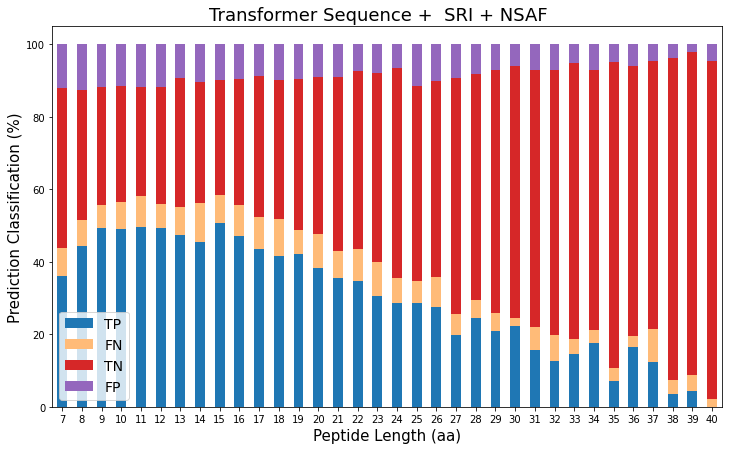

In [14]:
stacked_df = acc_by_len.iloc[:, 1:5].apply(lambda x: x*100/sum(x), axis=1) # calculate the percentage of each 
stacked_df.index = range(7, 41) # set the index to the peptide length

stacked_df.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("tab20", 9)),
          figsize=(12,7))

plt.title("Transformer Sequence +  SRI + NSAF   ", fontsize=18)
plt.xlabel("Peptide Length (aa)", fontsize=15)
plt.ylabel("Prediction Classification (%)", fontsize=15)
plt.legend(fontsize=14)
plt.xticks(rotation=360)
plt.savefig('stacked_confusion_matrix_transformer_20date_sequence_SRI_SAF_minmax_model_no_missed_cleaved25date.png', dpi=600, bbox_inches='tight')


plt.show()